In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 19 17:08:19 2024

@author: Rodrigo Meira
"""
from libs.eos_database import *
from libs.compressor_class import *
from libs.compression import *
from libs.gc_eos_soave import *
from libs.viscosity import *
from libs.plenum_system import *
from libs.simulation import *
from libs.model import *

from casadi import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import torch
from scipy.stats import qmc
from sklearn.model_selection import train_test_split

In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

vlv = valve(kv=0.38)
Vpp = 2.0 
Lc = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 4500, None, 1, 0, Aij, volumn_desviation, 'gas')
comp = CompressorClass()
visc = viscosity(mixture, volumn_desviation)
compressor = compression(gas, comp, visc)
plenum_sys = plenum(gas, compressor, vlv, Vpp, Lc, A1)

In [3]:
nAlphas = 300

sampler_N_RotS = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS = sampler_N_RotS.random(n=nAlphas+1)
N_RotS = qmc.scale(samples_N_RotS, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas = qmc.LatinHypercube(d=1)
samples_alphas = sampler_alphas.random(n=nAlphas+1)
alphas = qmc.scale(samples_alphas, 0.36, 0.65).flatten()

nData = 160
dt = 0.5
timestep = 3
x0 = [14.9919, 339.69, 0.42885]
z0 = [6245.39, 6245.39, 321.672, 0.445562, 319.423, 0.503621, 320.097, 0.396345, 339.69, 0.42885, 0.514917]
u0 = [4500, 300, 600, alphas[0], 5000]

In [4]:
# sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas, alphas, N_RotS, nData, dt, timestep)
# x_values, z_values, time_steps, alpha_values, N_values, x_train, y_train, x_min, x_max, y_min,y_max = sim.run()

# sim_data = {
#     "x_values": x_values,
#     "z_values": z_values,
#     "time_steps": time_steps,
#     "x_train": x_train,
#     "y_train": y_train,
#     "x_min": x_min,
#     "x_max": x_max,
#     "y_min": y_min,
#     "y_max": y_max

# }

# np.savez(
#     "simulation_data.npz",
#     x_values=x_values,
#     z_values=z_values,
#     time_steps=time_steps,
#     alpha_values=alpha_values,
#     N_values=N_values,
#     x_train=x_train,
#     y_train=y_train,
#     x_min=x_min,
#     x_max=x_max,
#     y_min = y_min,
#     y_max = y_max

# )


In [5]:
data = np.load("simulation_data.npz")

x_values = data["x_values"]
z_values = data["z_values"]
time_steps = data["time_steps"]
alpha_values = data["alpha_values"]
N_values = data["N_values"]
x_train = data["x_train"]
y_train = data["y_train"]
x_min = data["x_min"]
x_max = data["x_max"]
y_min = data["y_min"]
y_max = data["y_max"]


x_min = torch.tensor(x_min, dtype = torch.float32)
x_max = torch.tensor(x_max, dtype = torch.float32)
y_min = torch.tensor(y_min, dtype = torch.float32)
y_max = torch.tensor(y_max, dtype = torch.float32)
x_train = torch.tensor(np.array(x_train), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32)
x_train_split, X_val, y_train_split, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.3,  
    random_state=42,  
    shuffle=True      
)
y_train_split = y_train_split.squeeze()
y_val = y_val.squeeze()
train_dataset = torch.utils.data.TensorDataset(x_train_split, y_train_split)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 64, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= 64, shuffle=False)

In [6]:
model = MyModel(150, dt, x_max, x_min, y_min, y_max, plenum_sys)# Criar a instância do modelo novamente

In [7]:
# modelo = MyModel(200, dt, x_max, x_min, y_min, y_max, plenum_sys)  # mesma definição usada antes
# modelo.load_state_dict(torch.load('pesos_modelo.pth'))


In [8]:
train_loss_values = model.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr= 1e-4,
    epochs=10,
    optimizers=torch.optim.Adam,
    patience=2,
    factor=0.5,
    gas = gas
)

Batch 0 completed in 5.92s | Data: 27714.8984 | Phys: 3117.6257
Batch 1 completed in 3.24s | Data: 27824.8027 | Phys: 2755.9604
Batch 2 completed in 3.48s | Data: 24740.0352 | Phys: 3972.4441
Batch 3 completed in 3.24s | Data: 29368.3867 | Phys: 2542.6331
Batch 4 completed in 0.40s | Data: 26236.1699 | Phys: 2859.0078
Batch 5 completed in 3.45s | Data: 30746.1328 | Phys: 3544.2078
Batch 6 completed in 3.27s | Data: 30692.8906 | Phys: 3426.1692
Batch 7 completed in 3.29s | Data: 37329.2383 | Phys: 3098.5227
Batch 8 completed in 3.27s | Data: 24520.2285 | Phys: 2370.7065
Batch 9 completed in 3.38s | Data: 30836.1758 | Phys: 3374.4424
Batch 10 completed in 3.28s | Data: 28286.3457 | Phys: 3370.3992
Batch 11 completed in 3.29s | Data: 31503.2656 | Phys: 2753.8120
Batch 12 completed in 3.43s | Data: 29388.5879 | Phys: 3291.9546
Batch 13 completed in 0.36s | Data: 28371.9922 | Phys: 3005.0051
Batch 14 completed in 3.30s | Data: 28256.7988 | Phys: 2808.5767
Batch 15 completed in 3.35s | Data:

In [ ]:
torch.save(model.state_dict(), 'model.pth')


In [45]:
nAlphas_teste = 7

sampler_N_RotS_teste = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS_teste = sampler_N_RotS_teste.random(n=nAlphas_teste+1)
N_RotS_teste = qmc.scale(samples_N_RotS_teste, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas_teste = qmc.LatinHypercube(d=1)
samples_alphas_teste = sampler_alphas_teste.random(n=nAlphas_teste+1)
alphas_teste = qmc.scale(samples_alphas_teste, 0.35, 0.65).flatten()  

sim2 = sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas_teste, alphas_teste, N_RotS_teste, 160, dt, timestep)
x_values_teste, z_values_teste, time_steps, alpha_values_teste, N_values_teste, x_teste, y_teste, x_min, x_max, y_min, y_max = sim.run()
interval3 = np.linspace(0, 40*nAlphas_teste, len(x_teste))

In [35]:
import torch

# Rodar a inferência corretamente
model.eval()  # Importante colocar a rede em modo de avaliação
with torch.no_grad():
    y_pred = model(x_teste)

# Checar se y_pred realmente varia
for name, param in model.named_parameters():
    print(f"{name}: mean={param.mean().item()}, std={param.std().item()}")



lstm.weight_ih_l0: mean=0.0026283401530236006, std=0.07754460722208023
lstm.weight_hh_l0: mean=0.004233465995639563, std=0.0723472610116005
lstm.bias_ih_l0: mean=0.025407709181308746, std=0.06664407253265381
lstm.bias_hh_l0: mean=0.02995891310274601, std=0.06674926728010178
output_layer.weight: mean=5.489027898875065e-05, std=0.08793310075998306
output_layer.bias: mean=-0.0017133968649432063, std=0.05959461256861687


In [12]:
torch.onnx.export(
    model,
    x_teste,
    "modelo_simples12.onnx",
    export_params=True,
    opset_version=17,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},  # Permite batch variável
        "output": {0: "batch_size"},
    },
)

/home/matheus/.local/lib/python3.12/site-packages/torch/onnx/symbolic_opset9.py:4277: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [41]:
import onnxruntime as ort
import numpy as np

# Converter o tensor para NumPy e ajustar o dtype
x_teste_np = x_teste.detach().cpu().numpy().astype(np.float32)  # Garanta float32

# Se o modelo esperar um batch dimension (ex: [batch, seq_len, features]), adicione:
if x_teste_np.ndim == 1:
    x_teste_np = x_teste_np[np.newaxis, ...]  # Adiciona dimensão de batch (batch=1)

# Carregar o modelo ONNX
ort_session = ort.InferenceSession("modelo_simples11.onnx")

# Executar inferência corretamente
input_name = ort_session.get_inputs()[0].name
outputs = ort_session.run(None, {input_name: x_teste_np})[0]

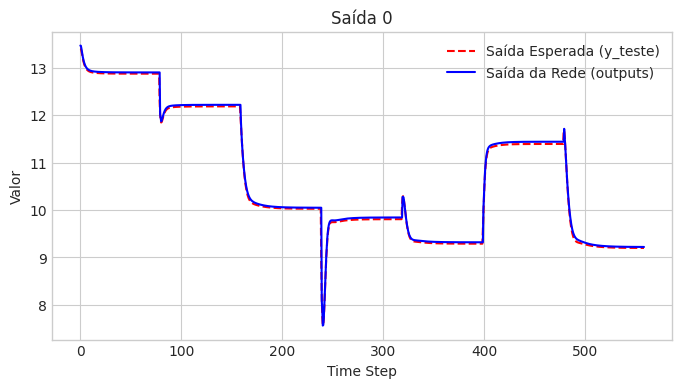

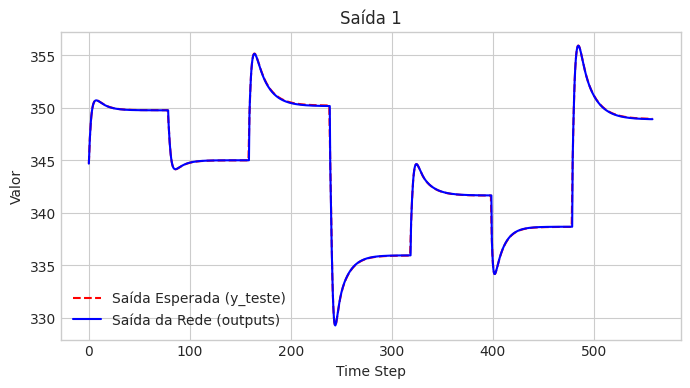

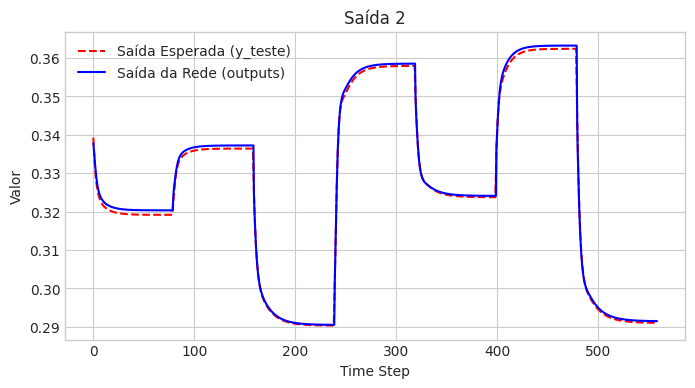

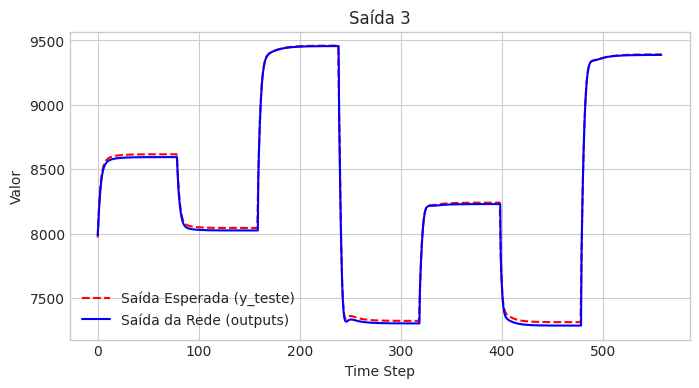

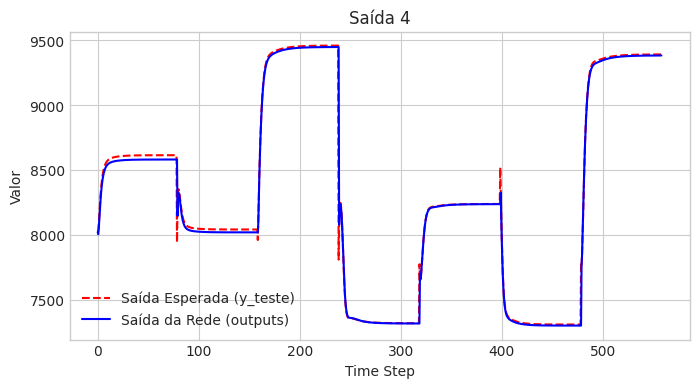

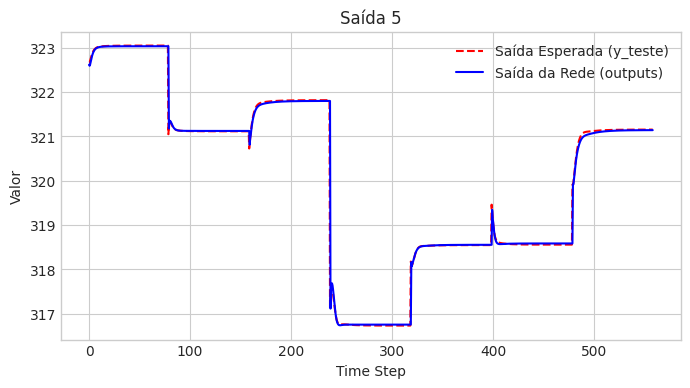

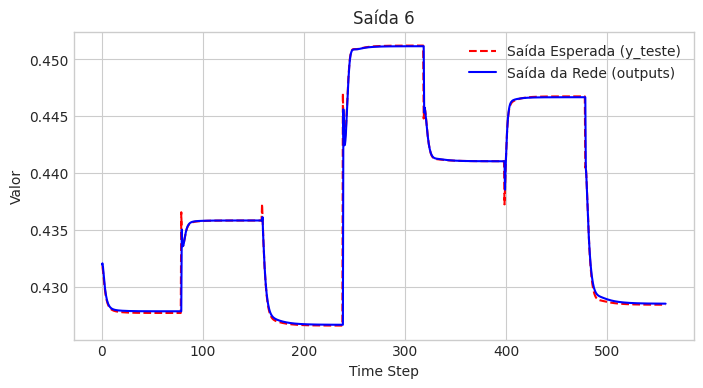

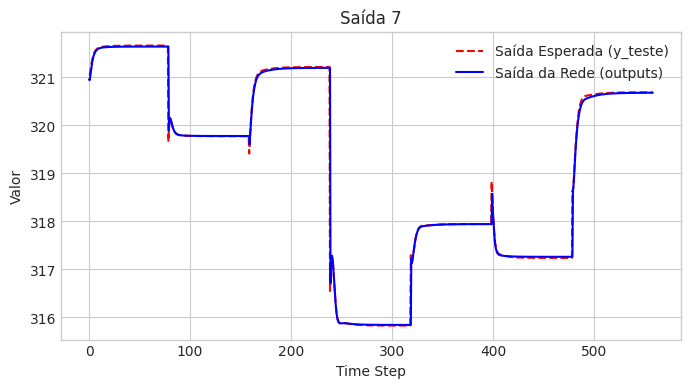

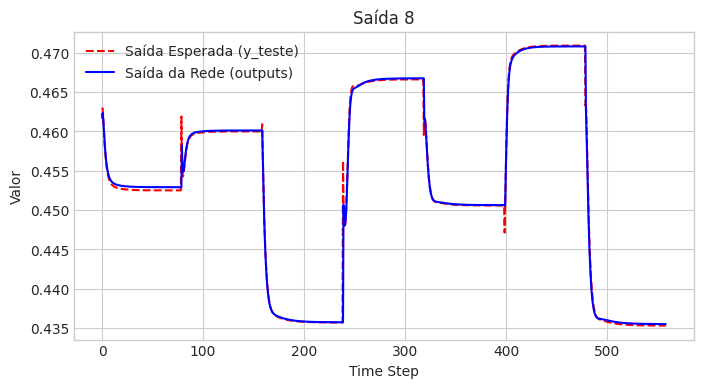

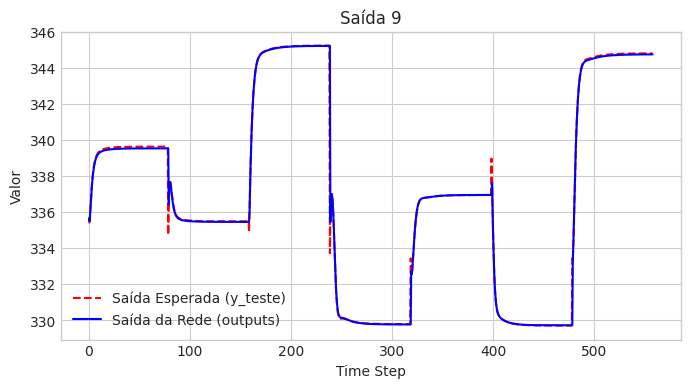

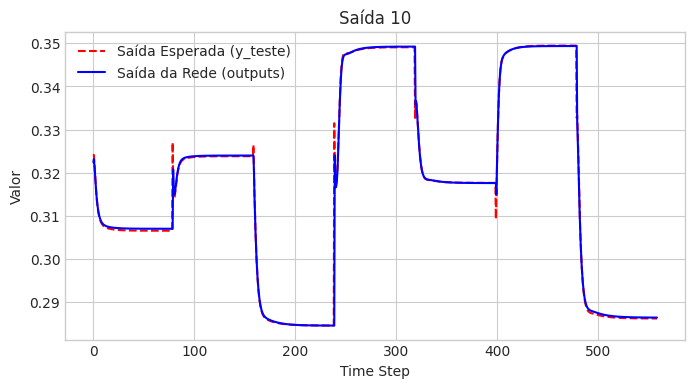

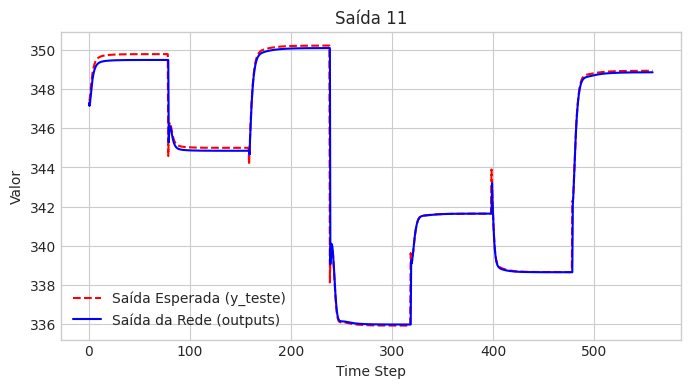

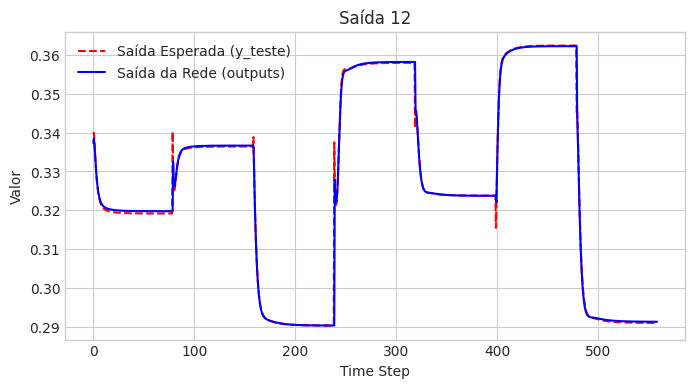

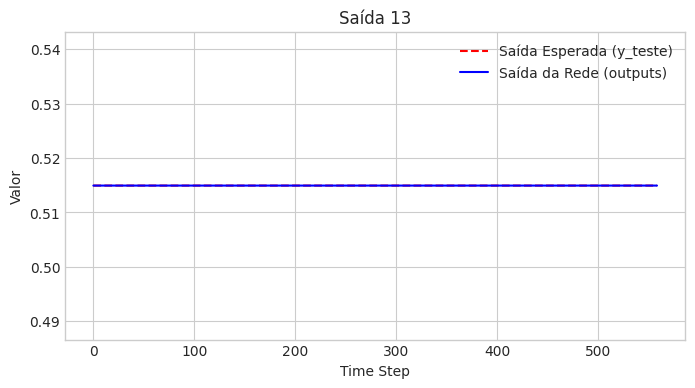

'[0, 1, 2, 3, 5, 7, 9, 11]'

In [42]:
import matplotlib.pyplot as plt

# Remover dimensões extras de y_pred e y_teste (se houver)
outputs = outputs.squeeze()
y_teste = y_teste.squeeze()

# Número de variáveis de saída
num_outputs = y_teste.shape[1]

# Ajustar o tamanho da lista time_steps para corresponder aos dados de teste
time_steps = time_steps[:y_teste.shape[0]]
 
# Criar os gráficos separadamente para cada saída
for i in range(num_outputs):
    plt.figure(figsize=(8, 4))  # Criar uma nova figura para cada gráfico
    plt.plot(time_steps, y_teste[:, i], label="Saída Esperada (y_teste)", color="red", linestyle="--")
    plt.plot(time_steps, outputs[:, i], label="Saída da Rede (outputs)", color="blue", linestyle="-")
    
    plt.xlabel("Time Step")
    plt.ylabel("Valor")
    plt.title(f"Saída {i}")  # Título do gráfico indicando o índice da saída
    plt.legend()
    plt.grid(True)
    
    plt.show()  # Mostrar o gráfico

"[0, 1, 2, 3, 5, 7, 9, 11]"

In [ ]:
print(x_teste.shape)

In [46]:
onnx_model_path = "./modelo_simples11.onnx"
onnx_session = ort.InferenceSession(onnx_model_path)

massFlowrate_pred = [x_teste[0, 0, 0].item(), x_teste[0, 1, 0].item(), x_teste[0, 2, 0].item()]
Temperatura = [x_teste[0, 0, 1].item(), x_teste[0, 1, 1].item(), x_teste[0, 2, 1].item()]
PlenumPressure_pred = [x_teste[0, 0, 2].item(), x_teste[0, 1, 2].item(), x_teste[0, 2, 2].item()]
Pressure2 = [x_teste[0, 0, 3].item(), x_teste[0, 1, 3].item(), x_teste[0, 2, 3].item()]
Temperatura2 = [x_teste[0, 0, 4].item(), x_teste[0, 1, 4].item(), x_teste[0, 2, 4].item()]

input_tensor = torch.zeros((1, 3, 7), dtype=torch.float32) 

tm1 = time.time()

for i in range(len(interval3)):
    # Atualizar os valores retroalimentados (massFlowrate e PlenumPressure)
    input_tensor[0, :, 0] = torch.tensor(massFlowrate_pred[-3:])
    input_tensor[0, :, 1] = torch.tensor(Temperatura[-3:])
    input_tensor[0, :, 2] = torch.tensor(PlenumPressure_pred[-3:])
    input_tensor[0, :, 3] = torch.tensor(Pressure2[-3:])
    input_tensor[0, :, 4] = torch.tensor(Temperatura2[-3:])
    input_tensor[0, :, 5] = x_teste[i, :, 5]
    input_tensor[0, :, 6] = x_teste[i, :, 6]
    # Copiar diretamente as variáveis restantes da entrada (colunas 2 a 6)

    # Previsão com ONNX
    onnx_inputs = {'input': input_tensor.numpy()}
    onnx_outputs = onnx_session.run(None, onnx_inputs)

    # Adicionar as novas previsões
    massFlowrate_pred.append(onnx_outputs[0][0][0])
    Temperatura.append(onnx_outputs[0][0][1])
    PlenumPressure_pred.append(onnx_outputs[0][0][3])
    Pressure2.append(onnx_outputs[0][0][4])
    Temperatura2.append(onnx_outputs[0][0][11])
tm2 = time.time()
timeteste = tm2 - tm1

print(f"Tempo de teste: {timeteste:.4f}s")
Temperatura = np.array(Temperatura)
lista = [massFlowrate_pred, Temperatura, PlenumPressure_pred, Pressure2, Temperatura2]
lista = np.array(lista)
print(lista.shape)

Tempo de teste: 0.1000s
(5, 1120)


/tmp/ipykernel_374064/1852148303.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_teste = np.array(y_teste)


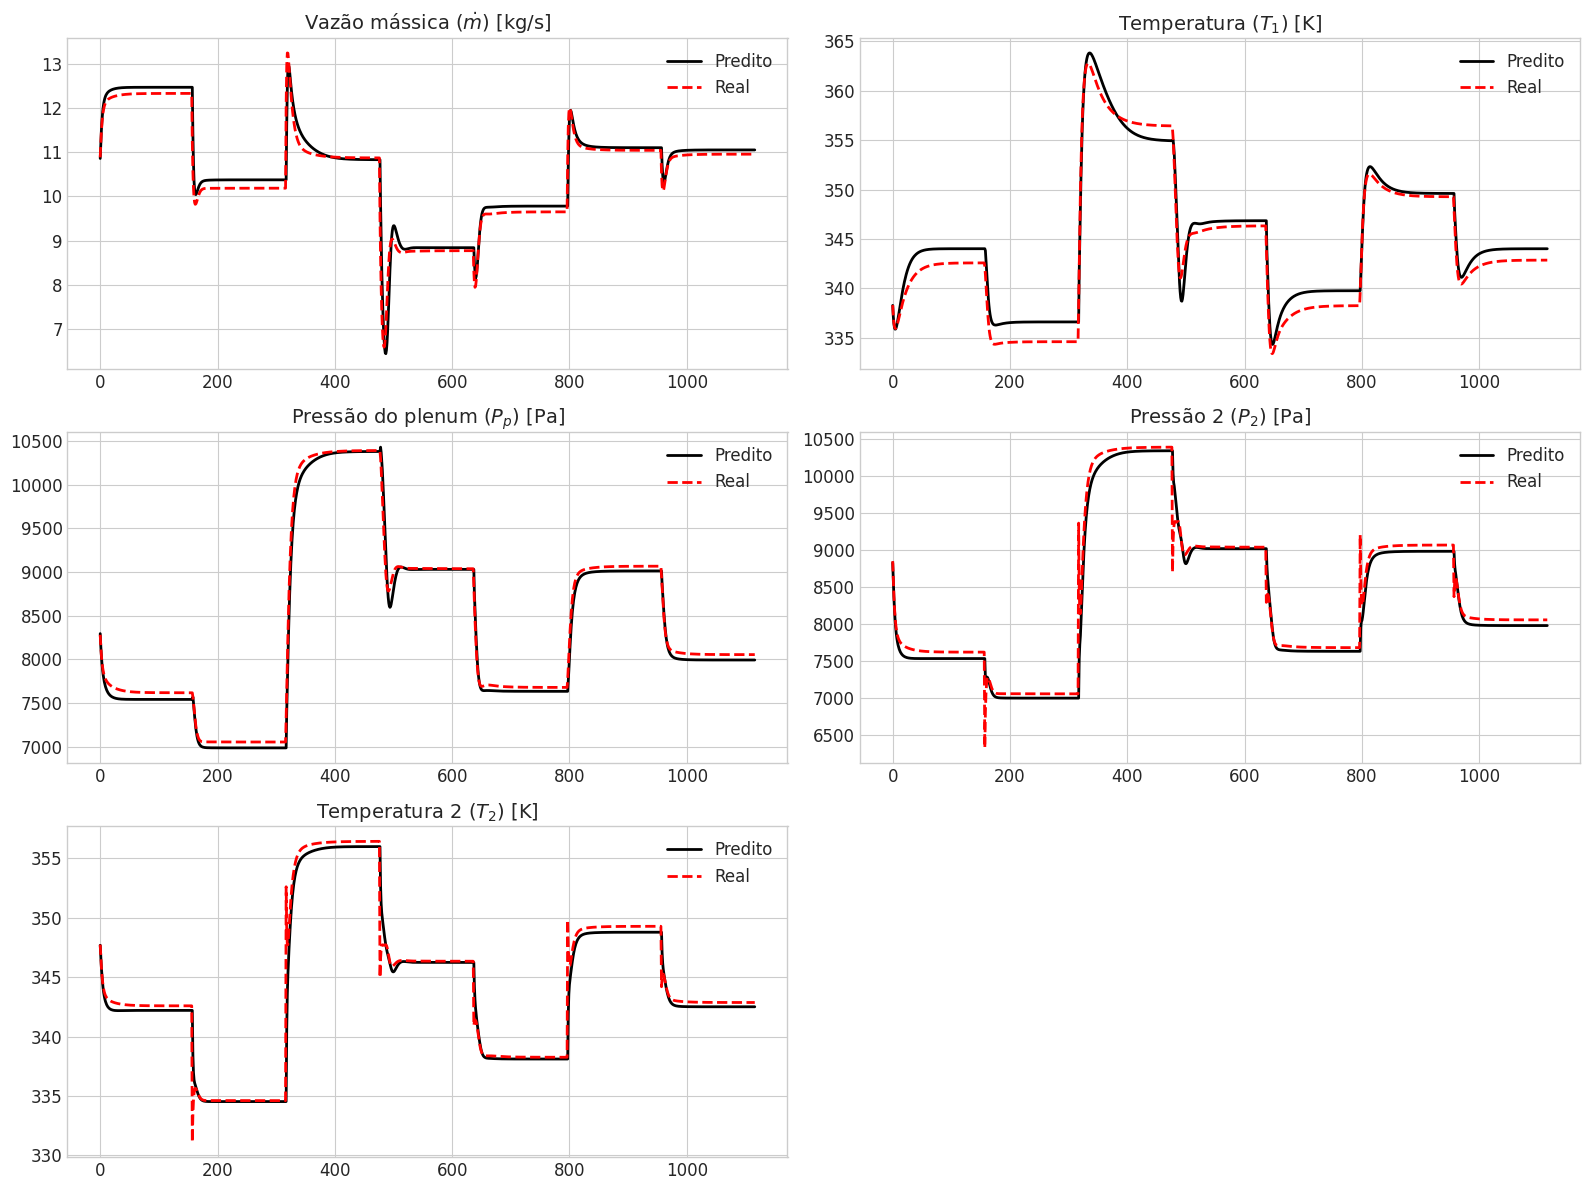

In [47]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-v0_8-whitegrid")

# Converter listas para numpy arrays
massFlowrate_pred = np.array(massFlowrate_pred[3:])
Temperatura_pred = np.array(Temperatura[3:])
PlenumPressure_pred = np.array(PlenumPressure_pred[3:])
Pressure2_pred = np.array(Pressure2[3:])
Temperatura2_pred = np.array(Temperatura2[3:])
y_teste = np.array(y_teste)

# Criar figura
fig, axs = plt.subplots(3, 2, figsize=(16, 12))
axs = axs.ravel()  # Deixa como vetor para indexar facilmente

# Títulos e unidades
titles_units = [
    (r'Vazão mássica ($\dot{m}$) [kg/s]', massFlowrate_pred, y_teste[:, 0]),
    (r'Temperatura ($T_1$) [K]', Temperatura_pred, y_teste[:, 1]),
    (r'Pressão do plenum ($P_p$) [Pa]', PlenumPressure_pred, y_teste[:, 3]),  # confirme o índice
    (r'Pressão 2 ($P_2$) [Pa]', Pressure2_pred, y_teste[:, 4]),              # confirme o índice
    (r'Temperatura 2 ($T_2$) [K]', Temperatura2_pred, y_teste[:, 11])        # confirme o índice
]

for i, (title, pred, real) in enumerate(titles_units):
    axs[i].plot(pred, label='Predito', color='black', linewidth=2)
    axs[i].plot(real, label='Real', color='red', linestyle='--', linewidth=2)
    axs[i].set_title(title, fontsize=14)
    axs[i].legend(fontsize=12)
    axs[i].tick_params(axis='both', labelsize=12)

# Remover último subplot vazio se necessário
fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()

